# Chapter 6 - Linear Model Selection and Regularization

In [32]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import Image
from patsy import dmatrices

from sklearn.preprocessing import scale 
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)

%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')

# Lab

In [3]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('Data/Hitters.csv').dropna().drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 40.1+ KB


In [4]:
df.head()

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  
5   336     194      A        W      282      421      25   750.0         A  

In [5]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
League_A       263 non-null float64
League_N       263 non-null float64
Division_E     263 non-null float64
Division_W     263 non-null float64
NewLeague_A    263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(6)
memory usage: 14.4 KB
   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
1         0         1           0           1            0            1
2         1         0           0           1            1            0
3         0         1           1           0            0            1
4         0         1           1           0            0            1
5         1         0           0           1            1            0


In [6]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null float64
Division_W     263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(19)
memory usage: 41.1 KB


In [7]:
X.head(5)

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  League_N  Division_W  NewLeague_N  
1   414     375      632       43      10         1           1            1  
2   266     263      880       82      14         0           1            0  
3   838     354      200       11       3         1           0            1  
4    46      33      805       40       4         1           0            1  
5   336     194      282      421      25         0           1            0  

### § 6.6.1 Ridge Regression 

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

For the __glmnet() function in R__ the penalty is defined as:
### $$ \lambda\bigg(\frac{1}{2}(1−\alpha)|\beta|^2_2 \ +\ \alpha|\beta|_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.html)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above penalty to
### $$ \frac{1}{2}\lambda |\beta|^2_2 $$
The __sklearn Ridge()__ function has the standard L2 penalty:
### $$ \lambda |\beta|^2_2 $$


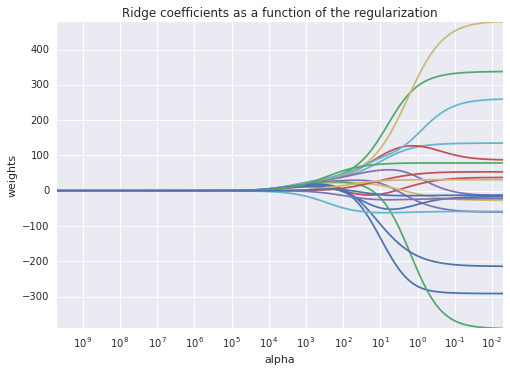

In [8]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [9]:
ridge2 = Ridge(alpha=4)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

104835.06228323364

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [10]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

172862.2200557664

#### Compute the regularization path using RidgeCV

In [11]:
ridgecv = RidgeCV(alphas=alphas, scoring='mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([  5.00000e+09,   3.78232e+09, ...,   6.60971e-03,   5.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='mean_squared_error', store_cv_values=False)

In [12]:
ridgecv.alpha_

66.097057423301436

In [13]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

101437.87891789108

In [31]:
pd.Series(ridge2.coef_, index=X.columns)

AtBat          -5.266903
Hits           42.293974
HmRun          -4.414799
Runs           18.300973
RBI            35.122753
Walks          50.045214
Years           4.266424
CAtBat         13.869952
CHits          34.924052
CHmRun         47.437613
CRuns          35.565533
CRBI           47.132307
CWalks         23.839983
PutOuts        87.503814
Assists        -2.311463
Errors         -2.639522
League_N       10.060616
Division_W    -47.990988
NewLeague_N     4.726928
dtype: float64

### § 6.6.2 The Lasso

For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

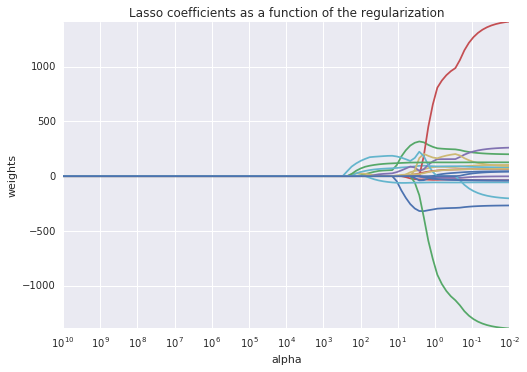

In [28]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')

In [15]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [16]:
lassocv.alpha_

27.503283261878408

In [17]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

106183.71692611944

In [18]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits            50.246197
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           66.794424
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          19.441152
CRuns            0.000000
CRBI           181.336557
CWalks           0.000000
PutOuts        110.307327
Assists         -0.000000
Errors          -0.000000
League_N         0.000000
Division_W     -44.530872
NewLeague_N      0.000000
dtype: float64

### § 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [19]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


          0         1         2         3         4         5
0  0.198290  0.383784 -0.088626  0.031967 -0.028117  0.070646
1  0.195861  0.377271 -0.074032  0.017982  0.004652  0.082240
2  0.204369  0.237136  0.216186 -0.235831 -0.077660  0.149646
3  0.198337  0.377721  0.017166 -0.049942  0.038536  0.136660
4  0.235174  0.314531  0.073085 -0.138985 -0.024299  0.111675

The above loadings are the same as in R.

In [20]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


          0         1         2         3         4         5
0 -0.009649 -1.870522 -1.265145 -0.935481 -1.109636 -1.211972
1  0.411434  2.429422  0.909193 -0.264212 -1.232031 -1.826617
2  3.466822 -0.825947 -0.555469 -1.616726  0.857488  1.028712
3 -2.558317  0.230984 -0.519642 -2.176251  0.820301 -1.491696
4  1.027702  1.573537 -1.331382  3.494004 -0.983427 -0.513675

The above principal components are the same as in R.

In [21]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 38.31,  60.15,  70.84,  79.03,  84.29,  88.63,  92.26,  94.96,
        96.28,  97.25,  97.97,  98.64,  99.14,  99.46,  99.73,  99.88,
        99.95,  99.98,  99.99])

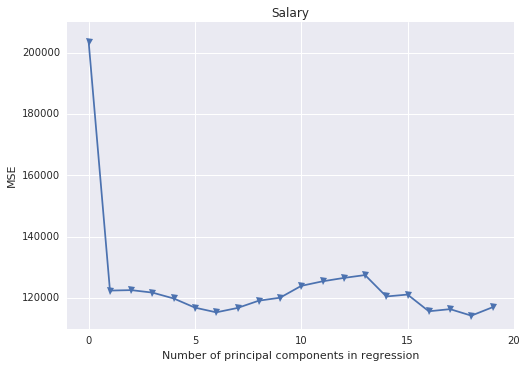

In [22]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 18 components.

In [23]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,   21.60350456,  -24.2942534 ,  -36.9858579 ,
         58.41402748,  -62.20632652,  -24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,  -20.99269291,
        -72.40210574, -276.68551696,   74.17098665, -422.72580227,
        347.05662353,  561.59691587,  -83.25441536])

#### Fitting PCA with training data

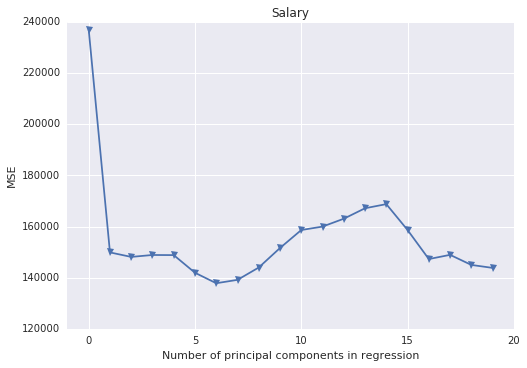

In [24]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [25]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111994.4227363699

### § 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

(-1, 20.0)

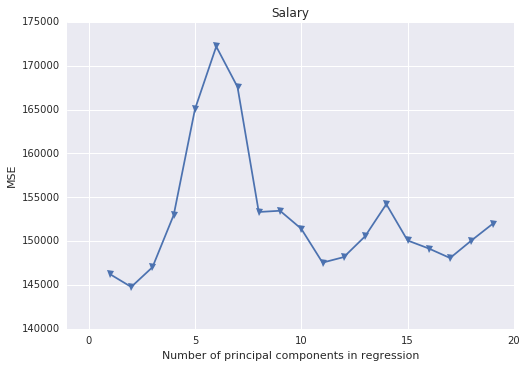

In [26]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_validation.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

In [27]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104711.20627773694